<a href="https://colab.research.google.com/github/Belashov641618/DNN/blob/main/collab/Incoherent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [2]:
!git clone https://github.com/Belashov641618/DNN.git

Cloning into 'DNN'...
remote: Enumerating objects: 653, done.
remote: Counting objects: 100% (253/253), done.
remote: Compressing objects: 100% (179/179), done.
remote: Total 653 (delta 124), reused 157 (delta 69), pack-reused 400
Receiving objects: 100% (653/653), 26.35 MiB | 23.10 MiB/s, done.
Resolving deltas: 100% (332/332), done.


In [3]:
!git pull

fatal: not a git repository (or any of the parent directories): .git


In [4]:
!dir
from google.colab import files
files.view('/content/DNN')
!dir

DNN  sample_data


<IPython.core.display.Javascript object>

DNN  sample_data


In [5]:
%cd DNN
import sys, os
sys.path.append(os.path.abspath('src'))

/content/DNN


In [6]:
!pip install belashovplot
from belashovplot.belashovplot import DefaultFont, DefaultBigHeader, DefaultHeader, DefaultDefault, DefaultCaption, DefaultSmallCaption
DefaultFont['font'] = 'DejaVu Sans'
for Font in [DefaultBigHeader, DefaultHeader, DefaultDefault, DefaultCaption, DefaultSmallCaption]:
  Font.Font = 'DejaVu Sans'

  Preparing metadata (setup.py) ... done
  Created wheel for belashovplot: filename=belashovplot-1.0-py3-none-any.whl size=12758 sha256=b89198cbf8ae661de46619debd6e6c53224d027f04b51c2711ef05546d26db6b
  Stored in directory: /root/.cache/pip/wheels/55/7b/e2/e5bf08c4c48d0989afbcb220497fa4bb6805a32f6c7826eece
Successfully built belashovplot


In [62]:
import torch
import torchvision
import numpy
import scipy
from itertools import product
from belashovplot import TiledPlot
from src.utilities.Formaters import Format
from src.utilities.CycleTimePredictor import CycleTimePredictor

In [8]:
from src.modules import layers
from src.utilities import decimal

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Просто задание рандомной фазы с помощью рандомной матрицы


In [132]:
torch.cuda.empty_cache()

pixels = 1023
wavelength = 532*decimal.nm
distance = 30.0*decimal.cm
length = 10*decimal.mm
samples = 10
padding = int(pixels*0.05)
focus = pixels*length*length / ((pixels*pixels - 1) * wavelength)
# 1/f = 1/a + 1/b -> 1/b = 1/f - 1/a -> b = af / (a - f)
distance = 2 * focus
distance_b = distance * focus / abs(distance - focus)

# distance = focus
# distance_b = focus

print(distance, distance_b, focus)

propagator = layers.FourierPropagationLayer(500.0*decimal.nm, 1.0, length, pixels, 1, distance, length).to(device)
propagator_b = layers.FourierPropagationLayer(500.0*decimal.nm, 1.0, length, pixels, 1, distance_b, length).to(device)
lens = layers.LensLayer(focus, wavelength, length, pixels, 1).to(device)
def model(data:torch.Tensor):
    return propagator_b(lens(propagator(data)))

from src.utilities.UniversalTestsAndOther import GenerateSingleUnscaledSampleMNIST
from torchvision.transforms.functional import resize, pad
from torchvision.transforms import InterpolationMode

with torch.no_grad():
  image = pad(resize(GenerateSingleUnscaledSampleMNIST(True).abs(), size=[pixels-2*padding, pixels-2*padding], interpolation=InterpolationMode.BICUBIC, antialias=True), [padding]*4, 0.)
  # image = torch.zeros_like(image)
  # s = 5
  # image[:,:, int(pixels/2)-s:int(pixels/2)+s, int(pixels/2)-s:int(pixels/2)+s] = 1.0
  coherent = image.clone().to(torch.complex64).to(device)
  incoherent = coherent.clone().expand(samples, 1, pixels, pixels) * torch.exp(2j*torch.pi*torch.rand(samples, 1, pixels, pixels, device=device, dtype=torch.float32))

  coherent_result = model(coherent)

  try_again = True
  split = 128
  while try_again:
    try:
      incoherent_results = torch.zeros_like(coherent_result, dtype=torch.float32)
      for part in torch.chunk(incoherent, split, dim=0):
          incoherent_results += torch.mean(torch.abs(model(part)), dim=0)
      incoherent_results /= split
      try_again = False
    except RuntimeError as e:
      split *= 2
      print(f'Split: {split}')

  M = pixels
  Na = int(M*distance/(distance+distance_b))
  Nb = int(M*distance_b/(distance+distance_b))
  cut = torch.zeros(Na + Nb, pixels)
  distances = numpy.linspace(0, distance, Na+1)[:-1]
  for i, distance_ in enumerate(distances):
    coherent_ = propagator(coherent)
    propagator.distance = distance_
    cut[i] = torch.abs(coherent_.squeeze()[int(pixels/2)].cpu())
  coherent_ = lens(coherent_)
  distances = numpy.linspace(0, distance_b, Nb)
  for i, distance_ in enumerate(distances, start=Na):
    propagator_b.distance = distance_
    cut[i] = torch.abs(propagator_b(coherent_).squeeze()[int(pixels/2)].cpu())

  coherent = coherent.squeeze().cpu()
  coherent_result = coherent_result.squeeze().cpu()
  incoherent_results = incoherent_results.squeeze().cpu()
  cut = cut.squeeze().cpu()

0.3674879851904712 0.3674879851904712 0.1837439925952356


KeyboardInterrupt: 

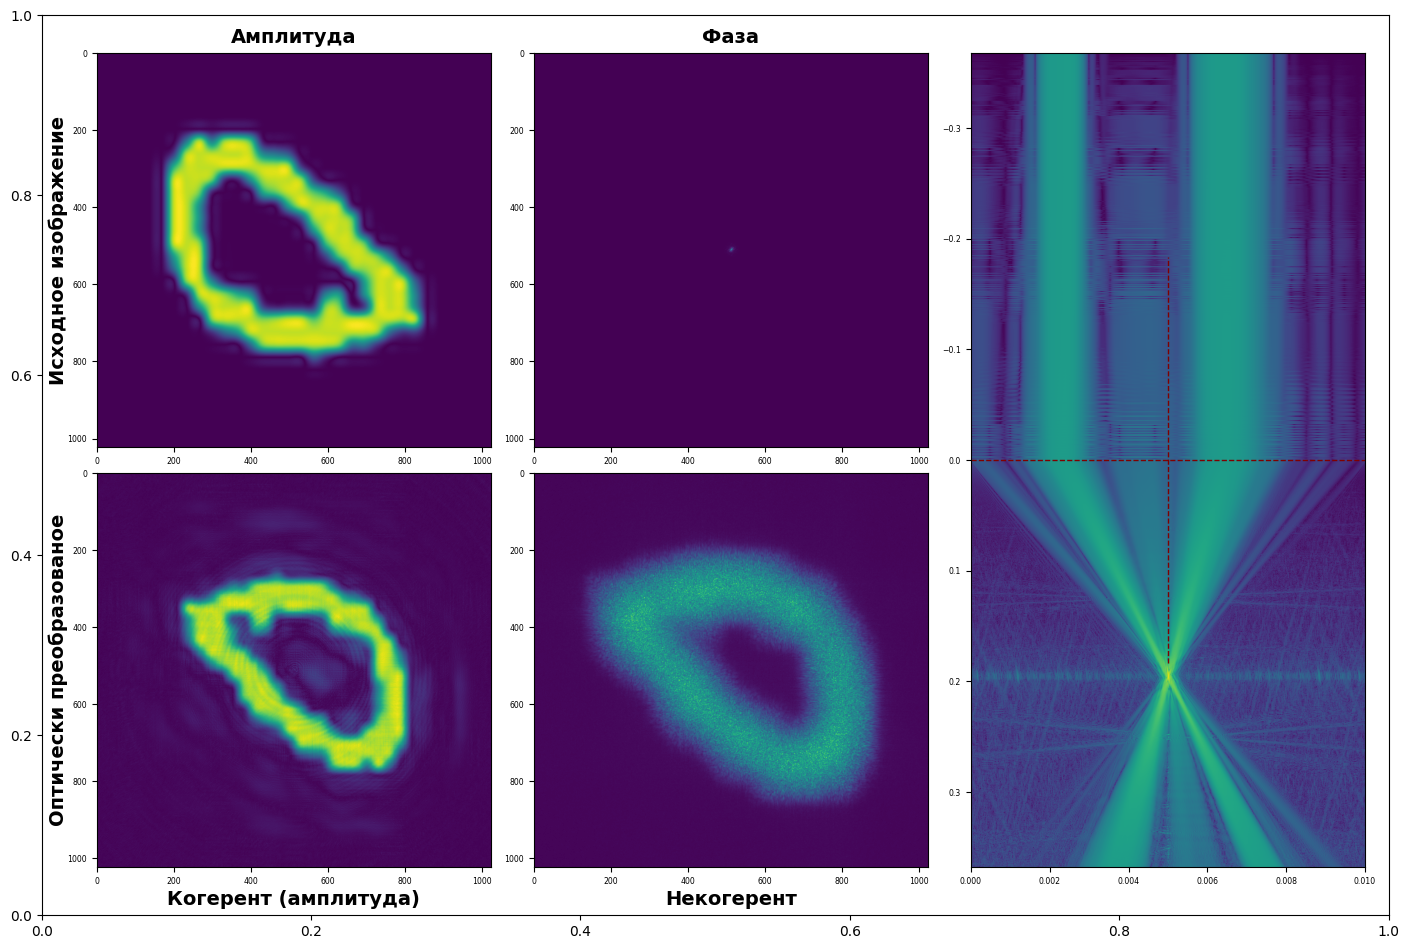

In [15]:
from belashovplot import TiledPlot

plot = TiledPlot(16,9)
plot.FontLibrary.MultiplyFontSize(0.7)

plot.description.row.left('Исходное изображение', 0)
plot.description.row.left('Оптически преобразованое', 1)
plot.description.column.top('Амплитуда', 0)
plot.description.column.top('Фаза', 1)
plot.description.column.bottom('Когерент (амплитуда)', 0)
plot.description.column.bottom('Некогерент', 1)

kwargs = {'aspect':'auto', 'cmap':'viridis'}

axes = plot.axes.add(0,0)
axes.imshow(torch.abs(coherent), **kwargs)

axes = plot.axes.add(1,0)
axes.imshow(torch.abs(torch.fft.fftshift(torch.fft.fft2(coherent))), **kwargs)

axes = plot.axes.add(0,1)
axes.imshow(torch.abs(coherent_result), **kwargs)

axes = plot.axes.add(1,1)
axes.imshow(incoherent_results, **kwargs)

axes = plot.axes.add((2,0), (2, 1))
axes.imshow(torch.log10(cut + 0.005), **kwargs, extent=[0, length, distance_b, -distance])
axes.axvline(length/2, (distance_b-focus)/(distance + distance_b), (distance_b+focus)/(distance + distance_b), color='maroon', linestyle='--', linewidth=1.0)
axes.axhline(0, color='maroon', linestyle='--', linewidth=1.0)

plot.show()

# Задание поля со случайном распределением



In [129]:
def modified_gauss(sigma_array:torch.Tensor, x_array:torch.Tensor):
  x_array = torch.remainder(x_array, 2*torch.pi)
  x_array = torch.where(x_array > torch.pi, x_array - 2*torch.pi, x_array)
  sigma_mesh, x_mesh = torch.meshgrid(sigma_array, x_array, indexing='ij')
  limits = torch.zeros_like(x_mesh, device=x_array.device)
  index = torch.abs(x_array).argmin()
  limits[:, index] = 1.0 * x_array.size(0) / (x_array[-1] - x_array[0])
  return torch.where(sigma_mesh != 0, torch.exp(-0.5*(x_mesh/sigma_mesh)**2) / (numpy.sqrt(2*torch.pi)*sigma_mesh*torch.erf(torch.pi / (numpy.sqrt(2)*sigma_mesh))), limits)

rows = 2
cols = 5

sigma_limits = (0, 1)
sigma_count = int(rows * cols)
sigma_array = torch.logspace(*sigma_limits, sigma_count, 10, device=device) - 1.0

x_limits = (-torch.pi, +torch.pi)
x_count = 100
x_array = torch.linspace(*x_limits, x_count, device=device)
dx = (x_limits[1] - x_limits[0]) / x_count

with torch.no_grad():
  results = modified_gauss(sigma_array, x_array)

  plot = TiledPlot(16, 8)
  plot.FontLibrary.MultiplyFontSize(0.7)
  for (row, col), data, sigma in zip(product(range(rows), range(cols)), results, sigma_array):
    sigma_str = Format.Scientific(sigma.item())
    # integral_str = Format.Scientific((torch.sum(data)*dx))
    integral_str = 1.0
    axes = plot.axes.add(col, row)
    axes.plot(x_array.cpu(), data.cpu())
    axes.grid(True)
    axes.set_ylim(0.,1.)
    plot.graph.description(f"$\sigma$ = {sigma_str}, $\sum$ = {integral_str}")

  plot.show()

KeyboardInterrupt: 

# Симуляция со случайно распределённой фазой

## Ядра свёртки

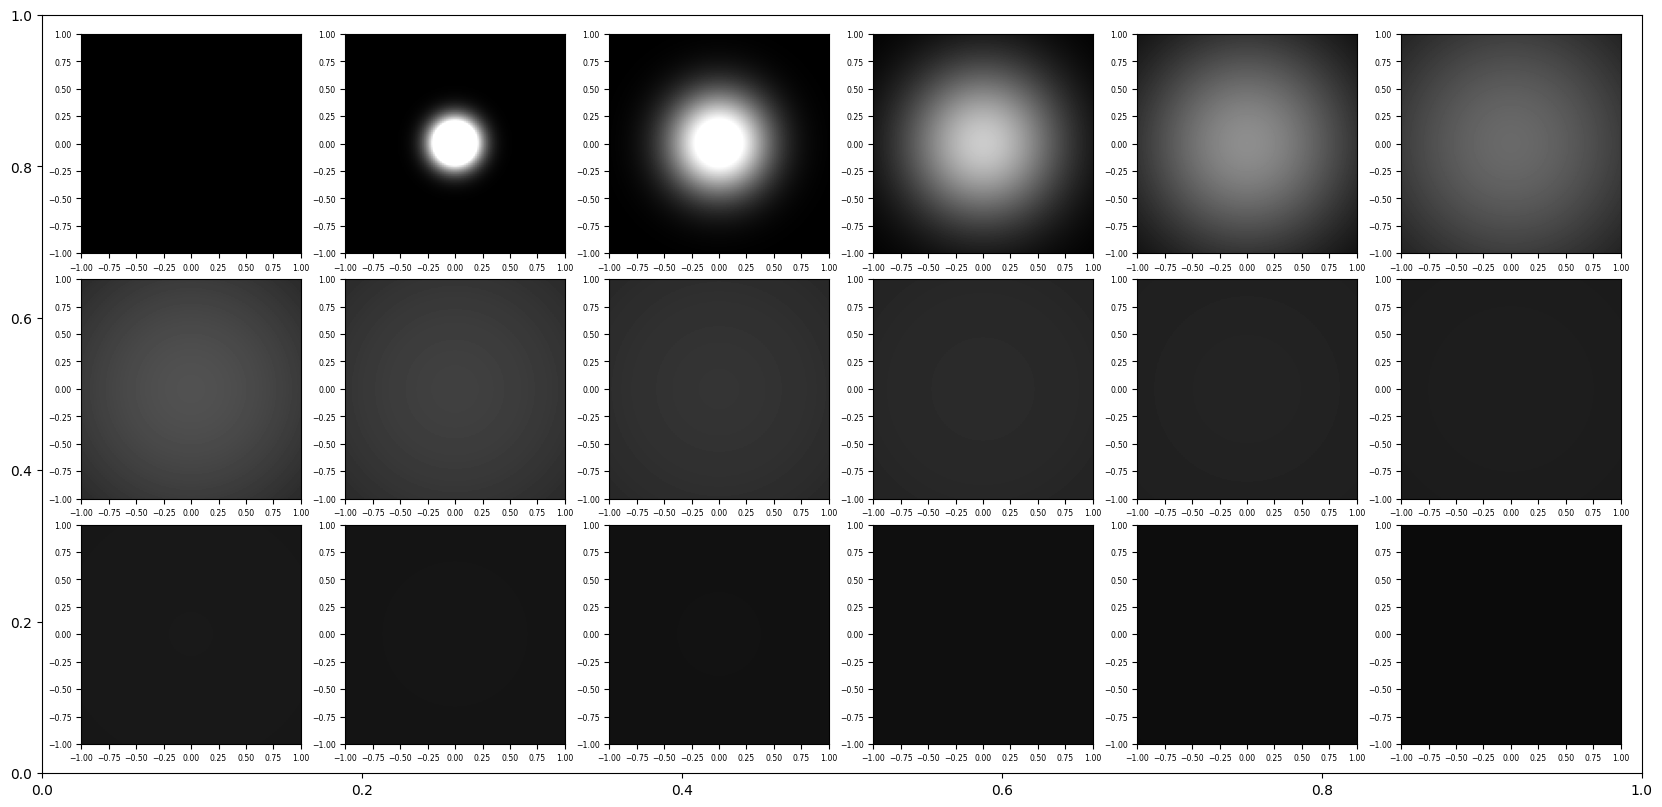

In [10]:
def convolution_core(Nx:int, Ny:int, x_lims:tuple[float,float], y_lims:tuple[float,float], sigma:float, mesh:bool=False):
  x_array = torch.linspace(*x_lims, Nx)
  y_array = torch.linspace(*y_lims, Ny)
  x_mesh, y_mesh = torch.meshgrid(x_array, y_array, indexing='xy')
  if sigma == 0:
    if mesh:
      return torch.zeros(Nx, Ny), x_mesh, y_mesh
    return torch.zeros(Nx, Ny)
  r_mesh = torch.sqrt(x_mesh**2 + y_mesh**2)
  if mesh:
    return (1.0 / (sigma*numpy.sqrt(2*torch.pi))) * torch.exp(-0.5*(r_mesh/sigma)**2), x_mesh, y_mesh
  return (1.0 / (sigma*numpy.sqrt(2*torch.pi))) * torch.exp(-0.5*(r_mesh/sigma)**2)

with torch.no_grad():
  cols = 6
  rows = 3
  N = 100

  lims = (-1.0, +1.0)
  sigmas = numpy.logspace(0, 1, int(cols*rows), 10) - 1.0

  plot = TiledPlot(16,9)
  plot.FontLibrary.MultiplyFontSize(0.7)
  for sigma, (row, col) in zip(sigmas, product(range(rows), range(cols))):
    z_mesh, x_mesh, y_mesh = convolution_core(N, N, lims, lims, sigma, True)
    axes = plot.axes.add((col, row), (col, row))
    axes.imshow(z_mesh, cmap='gray', aspect='auto', extent=[*lims, *lims], vmin=0., vmax=1.)
  plot.show()

## Распределение случайных величин и подгон параметров

In [107]:
def generate_field(N:int, sigma:float, lims:tuple[float,float], get_core:bool=False):
  padding = (N+1)//2
  random = torch.rand((N+2*padding, N+2*padding))
  core = torch.zeros((N+2*padding, N+2*padding))
  core[padding:padding+N, padding:padding+N] = convolution_core(N, N, lims, lims, sigma, False)
  core_spectrum = torch.fft.fftshift(torch.fft.fft2(core))
  random_spectrum = torch.fft.fftshift(torch.fft.fft2(random))
  result = torch.abs(torch.fft.ifft2(torch.fft.ifftshift(core_spectrum * random_spectrum)))[padding:padding+N, padding:padding+N]
  result = (result - result.min()) / (result.max() - result.min())
  if get_core:
      return result, core[padding:padding+N, padding:padding+N]
  return result

def calc_distribution(N:int, data:torch.Tensor):
  drange = torch.linspace(data.min(), data.max(), N)
  results = torch.zeros(N)
  data = data.flatten()
  for i, value in enumerate(drange):
    results[i] = torch.sum(data <= value) / data.numel()
  return results, drange

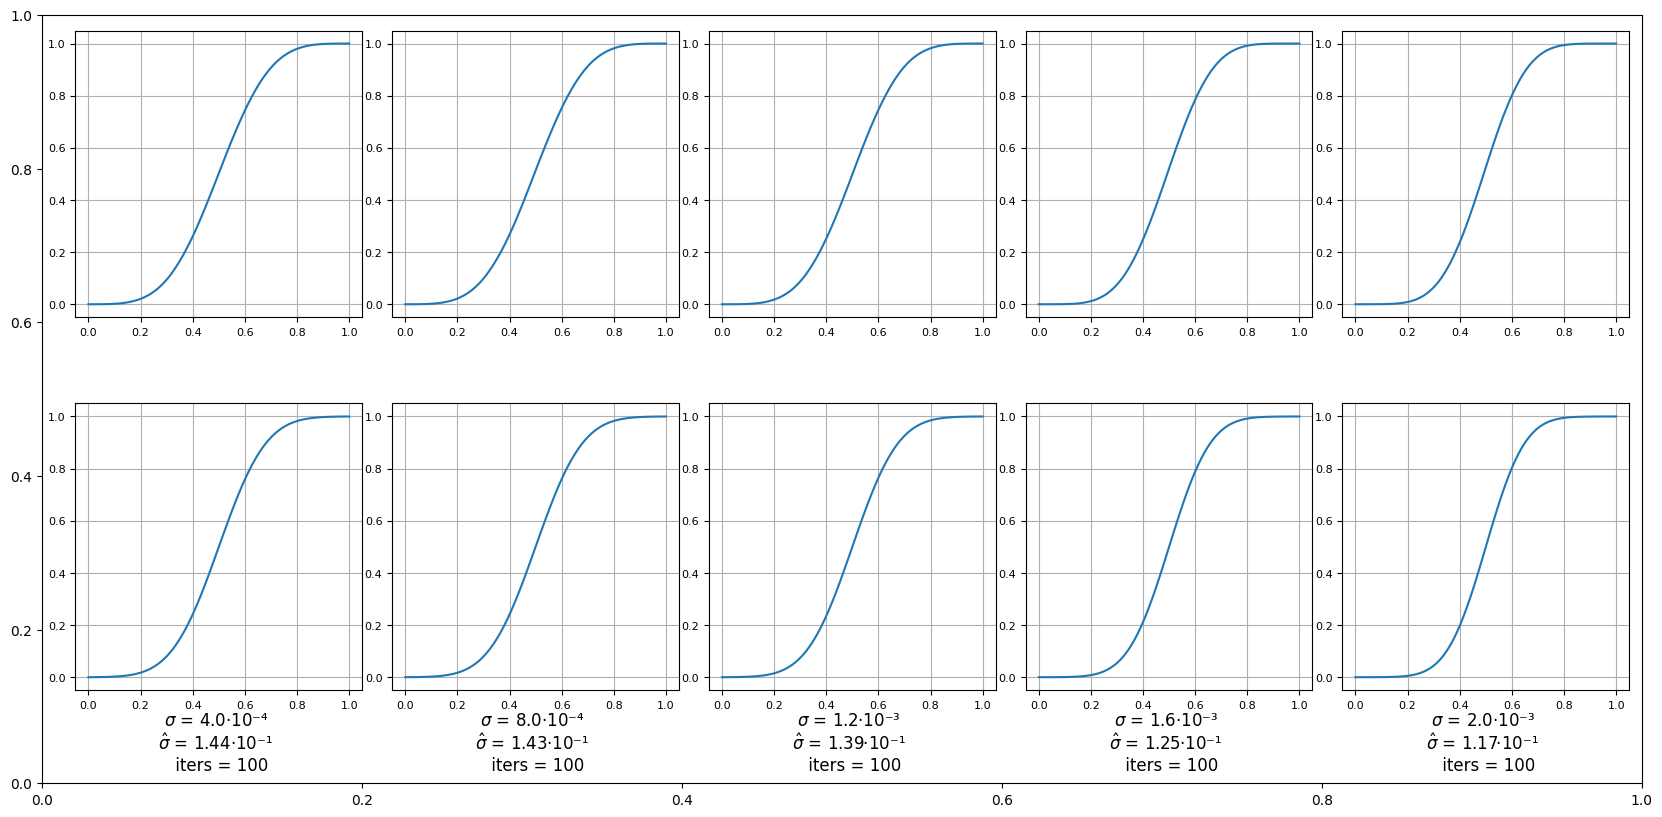

In [101]:
def function(N:int, sigma_:float):
  x = torch.linspace(0., 1., N)
  y = 0.5 * (torch.erf((x - 0.5)/(sigma_*numpy.sqrt(2))) / torch.erf(1.0 / (sigma_*2*numpy.sqrt(2))) + 1.0)
  return x, y

def comparison(a, b):
  return torch.mean((a-b)**2)

cols = 5
rows = 1
N = 1000

lims = (-1.0, +1.0)
sigmas = numpy.linspace(0, 0.002, int(rows*cols)+1)[1:]

plot = TiledPlot(16,9)
plot.FontLibrary.MultiplyFontSize(1.0)
for (col, row), sigma in zip(product(range(cols), range(rows)), sigmas):
  with torch.no_grad():
    field = generate_field(N, sigma, lims, False)
    distribution, drange = calc_distribution(100, field)
  axes = plot.axes.add(col, 2*row)
  axes.plot(drange, distribution.cpu())
  axes.grid(True)

  param = torch.tensor([1.0], requires_grad=True)
  optimizer = torch.optim.Adam([param], lr=0.01)
  prev_loss = 0
  curr_loss = 1.0
  iter = 0
  while iter < 100:
    optimizer.zero_grad()
    x, y = function(100, param)
    loss = comparison(y, distribution)
    loss.backward()
    optimizer.step()

    prev_loss = curr_loss
    curr_loss = loss.item()
    iter += 1

  axes = plot.axes.add(col, 2*row+1)
  axes.plot(x.detach().numpy(), y.detach().numpy())
  axes.grid(True)

  plot.graph.description(f"$\sigma$ = {Format.Scientific(sigma, '', 2)} \n$\hat\sigma$ = {Format.Scientific(param.detach().item(), '', 2)} \n iters = {iter}")

plot.show()

## Получение линейной зависимости

In [111]:
samples = 100
N = 500

lims = (-1.0, +1.0)
sigmas = numpy.linspace(0, 0.125, int(samples)+1)[1:]
sigmas_ = numpy.zeros(samples)

for i, sigma in enumerate(CycleTimePredictor(sigmas)):
  with torch.no_grad():
    field = generate_field(N, sigma, lims, False)
    distribution, drange = calc_distribution(100, field)

  param = torch.tensor([1.0], requires_grad=True)
  optimizer = torch.optim.Adam([param], lr=0.01)
  prev_loss = 0
  curr_loss = 1.0
  iter = 0
  while iter < 100:
    optimizer.zero_grad()
    x, y = function(100, param)
    loss = comparison(y, distribution)
    loss.backward()
    optimizer.step()

    prev_loss = curr_loss
    curr_loss = loss.item()
    iter += 1
  sigmas_[i] = param.detach().clone().item()

Итерация: 100 из 100 | Прошло времени: 38s578ms из 38s578ms, Осталось: 0us0ns   


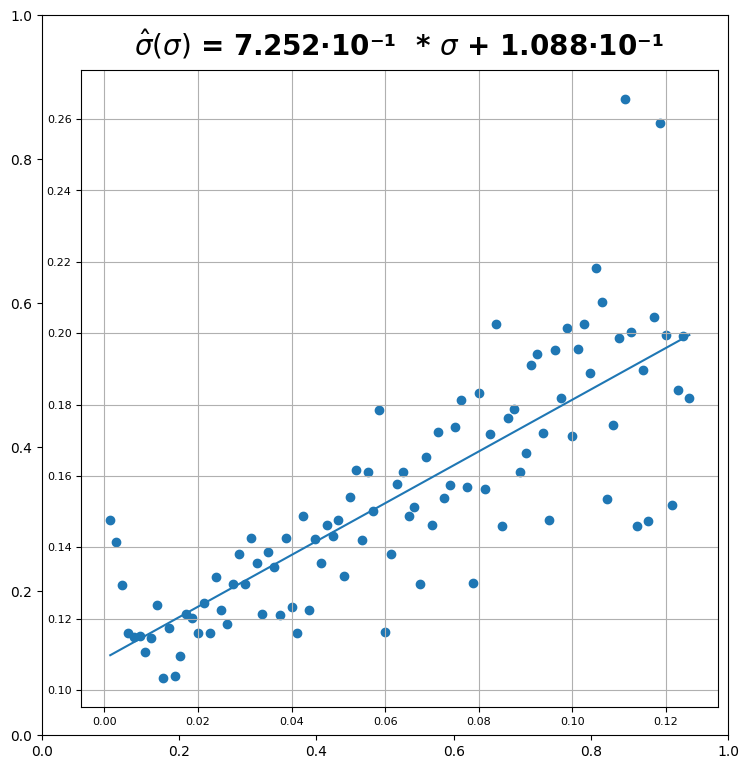

In [112]:
coefficients = numpy.polyfit(sigmas, sigmas_, 1)
sigmas__ = numpy.poly1d(coefficients)(sigmas)

plot = TiledPlot(16*0.8,9*0.8)
plot.FontLibrary.MultiplyFontSize(1.0)
axes = plot.axes.add(0,0)
axes.grid(True)
axes.scatter(sigmas, sigmas_)
axes.plot(sigmas, sigmas__)
plot.graph.title(f"$\hat\sigma(\sigma)$ = {Format.Scientific(coefficients[0])} * $\sigma$ + {Format.Scientific(coefficients[1])}")
plot.show()

In [115]:
def normalize_uniform(data:torch.Tensor, sigma:float):
  sigma_ = 7.252E-1 * sigma  +  1.088E-1
  result = 0.5 * (torch.erf((data - 0.5)/(sigma_*numpy.sqrt(2))) / scipy.special.erf(1.0 / (sigma_*2*numpy.sqrt(2))) + 1.0)
  result = (result - result.min()) / (result.max() - result.min())
  return result

## Тестирование

/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:1355: RuntimeWarning: overflow encountered in divide
  resdat /= (vmax - vmin)


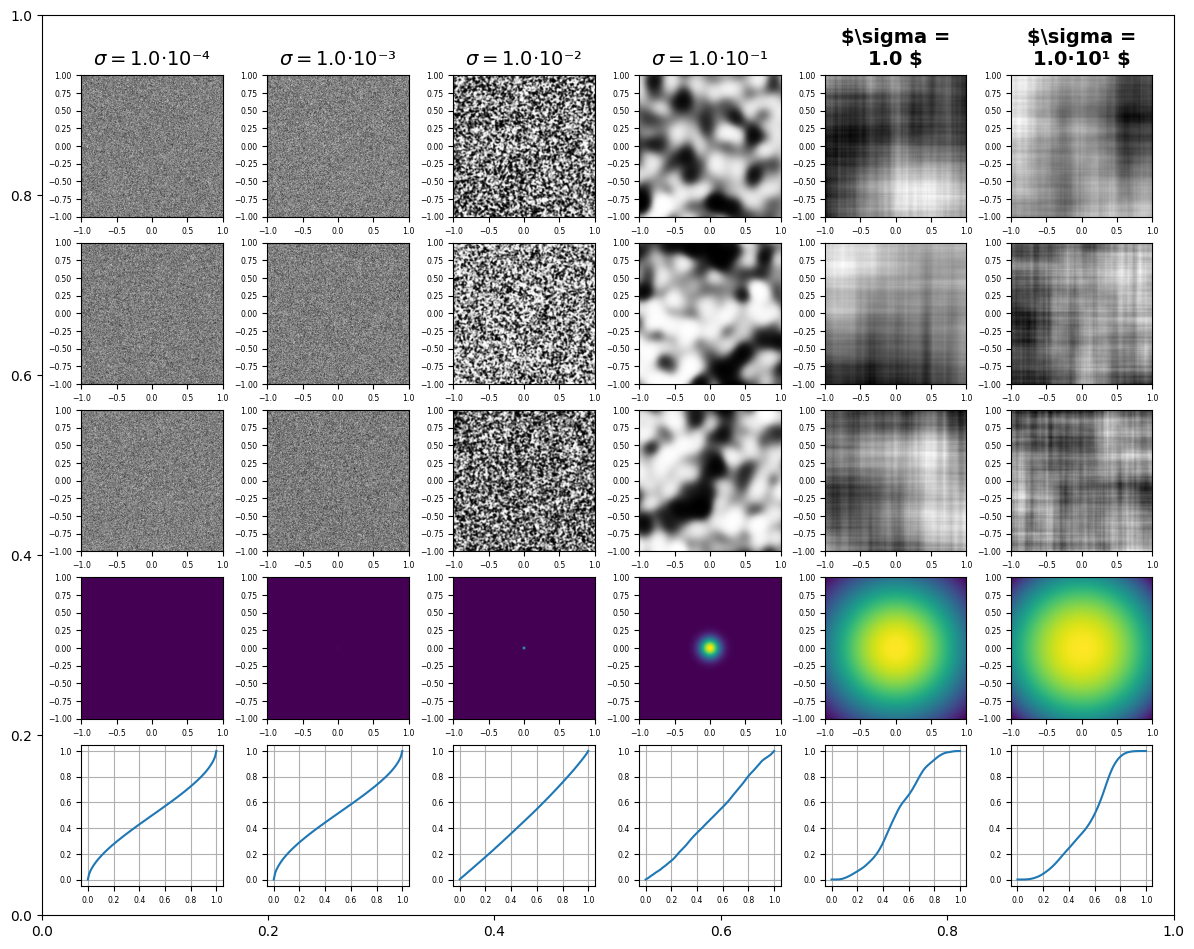

In [116]:
def generate_incoherent(N:int, sigma:float, lims:tuple[float,float], return_core:bool=False):
  if return_core:
    field, core = generate_field(N, sigma, lims, True)
    field = normalize_uniform(field, sigma)
    return field, core
  field = generate_field(N, sigma, lims, False)
  field = normalize_uniform(field, sigma)
  return field

with torch.no_grad():
  cols = 6
  rows = 5
  N = 1000

  lims = (-1.0, +1.0)
  sigmas = numpy.logspace(-4, 1, cols)

  plot = TiledPlot(16,9)
  plot.FontLibrary.MultiplyFontSize(0.7)
  for col, sigma in zip(range(cols), sigmas):
    field, core = generate_incoherent(N, sigma, lims, True)
    axes = plot.axes.add(col, rows-2)
    axes.imshow(core, cmap='viridis', aspect='auto', extent=[*lims, *lims])
    plot.description.column.top(f'$\sigma = {Format.Scientific(sigma, "", 2)}$', col)

    distribution, drange = calc_distribution(100, field)
    axes = plot.axes.add(col, rows-1)
    axes.plot(drange, distribution.cpu())
    axes.grid(True)

    for row in range(rows-2):
      field = generate_incoherent(N, sigma, lims, False)
      axes = plot.axes.add(col, row)
      axes.imshow(field, cmap='gray', aspect='auto', extent=[*lims, *lims])
  plot.show()

## Автокорреляция

Итерация: 100 из 100 | Прошло времени: 1m6s из 1m6s, Осталось: 0us0ns   


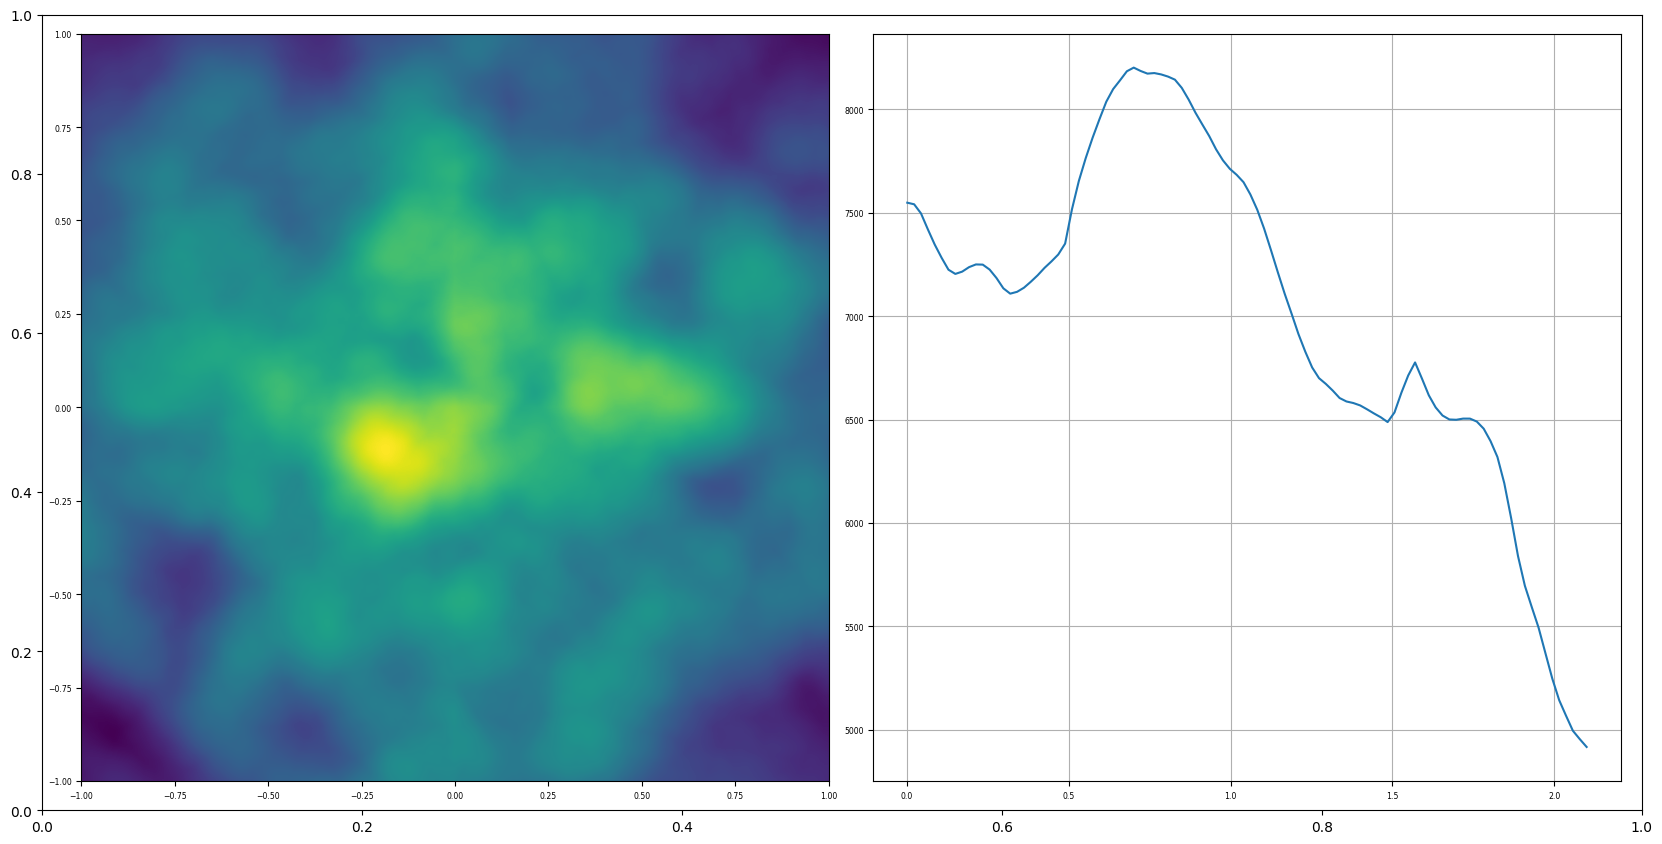

In [128]:
def fast_equal_convolution(a:torch.Tensor, b:torch.Tensor, N:int):
  padding = (N+1)//2
  a_padded = torch.zeros((N+2*padding, N+2*padding))
  a_padded[padding:padding+N, padding:padding+N] = a
  b_padded = torch.zeros((N+2*padding, N+2*padding))
  b_padded[padding:padding+N, padding:padding+N] = b

  return torch.abs(torch.fft.ifftshift(torch.fft.ifft2(torch.fft.fftshift(torch.fft.fft2(a_padded)) * torch.fft.fftshift(torch.fft.fft2(b_padded))))[padding:padding+N, padding:padding+N])

def autoconvolution(a:torch.Tensor, N:int):
  a = a - torch.mean(a, keepdim=True, dim=(0,1))
  return fast_equal_convolution(a, a, N)

def autocorrelation(N:int, lims:tuple[float,float], sigma:float, samples:int=10):
  autoconvolutions = torch.zeros((samples,N,N))
  for i in CycleTimePredictor(list(range(samples))):
    autoconvolutions[i] = autoconvolution(generate_incoherent(N, sigma, lims, False), N)
  return torch.mean(autoconvolutions, dim=0)

with torch.no_grad():
  N = 1000
  M = 100
  lims = (-1., +1.)
  samples = 100
  sigma = 0.1

  results_xy = autocorrelation(N, lims, sigma, samples)

  x_mesh, y_mesh = torch.meshgrid(torch.linspace(*lims, N), torch.linspace(*lims, N), indexing='xy')
  r_mesh = torch.sqrt((x_mesh - 0.5)**2 + (y_mesh - 0.5)**2)
  r_array = torch.linspace(r_mesh.min(), r_mesh.max(), M+1)
  r_begin = r_array[:-1]
  r_end = r_array[1:]

  results_r = torch.zeros((M))
  for i, (r0, r1) in enumerate(zip(r_begin, r_end)):
    mask = (r_mesh <= r1) * (r0 < r_mesh)
    average = numpy.sum(numpy.where(mask, results_xy, 0)) / torch.sum(mask)
    results_r[i] = average

  plot = TiledPlot(16,9)
  plot.FontLibrary.MultiplyFontSize(0.7)

  axes = plot.axes.add(0,0)
  axes.imshow(results_xy, aspect='auto', extent=[*lims, *lims])

  axes = plot.axes.add(1,0)
  axes.grid(True)
  axes.plot(r_begin, results_r)

  plot.show()



## Распределение фазы

In [131]:
def channelise_incoherent(images:torch.Tensor, length:float, coherence:float, samples:int=20):
  if images.size(1) != 1: raise AttributeError
  size = [*images.size()]
  size[1] = samples
  images_ = torch.zeros(size, dtype=images.dtype, device=images.device)
  for batch, image in enumerate(images):
    for i in range(samples):
      images_[batch,i] = image * torch.exp(2j*torch.pi*generate_incoherent(size[2], coherence, (-length/2,+length/2), False))
  return images_

In [156]:
torch.cuda.empty_cache()

pixels = 511
wavelength = 532*decimal.nm
distance = 30.0*decimal.cm
length = 10*decimal.mm
samples = 10
padding = int(pixels*0.05)
focus = pixels*length*length / ((pixels*pixels - 1) * wavelength)
# 1/f = 1/a + 1/b -> 1/b = 1/f - 1/a -> b = af / (a - f)
distance = 2 * focus
distance_b = distance * focus / abs(distance - focus)

# distance = focus
# distance_b = focus

print(distance, distance_b, focus)

propagator = layers.FourierPropagationLayer(500.0*decimal.nm, 1.0, length, pixels, 1, distance, length).to(device)
propagator_b = layers.FourierPropagationLayer(500.0*decimal.nm, 1.0, length, pixels, 1, distance_b, length).to(device)
lens = layers.LensLayer(focus, wavelength, length, pixels, 1).to(device)
def model(data:torch.Tensor):
    return propagator_b(lens(propagator(data)))

from src.utilities.UniversalTestsAndOther import GenerateSingleUnscaledSampleMNIST
from torchvision.transforms.functional import resize, pad
from torchvision.transforms import InterpolationMode

with torch.no_grad():
  image = pad(resize(GenerateSingleUnscaledSampleMNIST(True).abs(), size=[pixels-2*padding, pixels-2*padding], interpolation=InterpolationMode.BILINEAR, antialias=True), [padding]*4, 0.)
  coherent = image.clone().to(torch.complex64).to(device)
  incoherent = channelise_incoherent(coherent, length, length/100, samples)

  coherent_result = model(coherent)

  try_again = True
  split = 128
  while try_again:
    try:
      incoherent_results = torch.zeros_like(coherent_result, dtype=torch.float32)
      for part in torch.chunk(incoherent, split, dim=1):
          incoherent_results += torch.mean(torch.abs(model(part)), dim=1)
      incoherent_results /= split
      try_again = False
    except RuntimeError as e:
      split *= 2
      print(f'Split: {split}')

  coherent = coherent.squeeze().cpu()
  coherent_result = coherent_result.squeeze().cpu()
  incoherent = incoherent.squeeze().cpu()
  incoherent_results = incoherent_results.squeeze().cpu()

0.7356972394220846 0.7356972394220846 0.3678486197110423


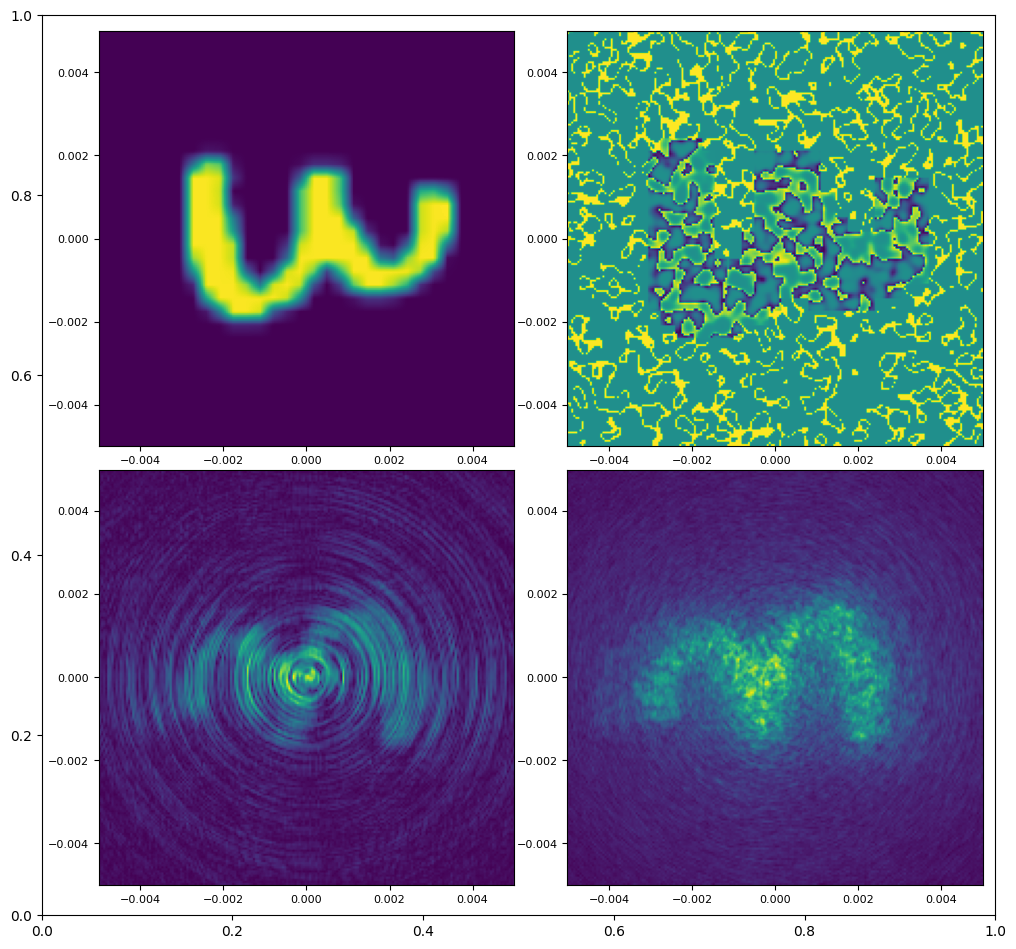

In [155]:
plot = TiledPlot(16, 9)

kwargs = {
    'aspect':'auto',
    'extent':[-length/2,+length/2]*2,
    'cmap':'viridis'
}

axes = plot.axes.add(0,0)
axes.imshow(torch.abs(coherent), **kwargs)

axes = plot.axes.add(1,0)
axes.imshow(torch.angle(incoherent[0]), **kwargs)

axes = plot.axes.add(0,1)
axes.imshow(torch.abs(coherent_result), **kwargs)

axes = plot.axes.add(1,1)
axes.imshow(torch.abs(incoherent_results), **kwargs)

plot.show()